In [ ]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
from sklearn.ensemble import IsolationForest
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from scipy.sparse import csr_matrix,hstack
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from wordcloud import STOPWORDS
from wordcloud import WordCloud

import nltk
#Uncomment below part when you are using for first time
nltk.download('stopwords')
from nltk.corpus import stopwords

import gc
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Loading dataset
df = pd.read_csv("/content/drive/MyDrive/train.csv",sep='\t')
#Printing shape of the dataset
print(f"data shape {df.shape}")

Mounted at /content/drive
data shape (1482535, 8)


In [ ]:
#Looking datatypes of each column in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [ ]:
#one look at table by showing first 5 records
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
#Getting Somes stats about data
df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [ ]:
#Finding missing records for each column in dataset
missing_data = pd.DataFrame({"Missing_value_Percentage":round(df.isna().sum()/len(df),3)*100})
missing_data.reset_index()
missing_data

,Missing_value_Percentage
train_id,0.0
name,0.0
item_condition_id,0.0
category_name,0.4
brand_name,42.7
price,0.0
shipping,0.0
item_description,0.0


**Data Preprocessing**

In [ ]:
#Converting str values into lower case for each cat col
df['category_name'] = df['category_name'].apply(lambda x : str(x).lower())
df['name'] = df['name'].apply(lambda x : str(x).lower())
df['brand_name'] = df['brand_name'].apply(lambda x : str(x).lower())
df['item_description'] = df['item_description'].apply(lambda x : str(x).lower())

In [ ]:
#Preprocessing category name replacing less occuring values as other
result = df.category_name.value_counts().to_dict()
final = dict()
#storing less occuring values in dict as keys
for k,v in result.items():
  if v <= 10:
    #storing value for them as others
    final[k]='others'

#Replacing values using replace method
df['category_name'] = df['category_name'].replace(final)
#Less no of misssing valuess present in this column so simply replacing it by missing u can use mode as well
df['category_name'].fillna('missing',inplace=True)
#Removing Special Characters & Numbers
#df['category_name'] = df['category_name'].str.replace('[^A-Za-z]+',' ')
df[["main_category","sub_category_1","sub_category_2"]] = df['category_name'].str.split('/',expand=True).drop([3,4],axis=1)

In [ ]:
#Converting brands as others which are not reflecting too much
result = df.brand_name.value_counts().to_dict()
final = dict()
#storing less occuring values in dict as keys
for k,v in result.items():
  if v <= 10:
    #storing value for them as others
    final[k]='others'
#Replacing values using replace method
df['brand_name'] = df['brand_name'].replace(final)
#Replacing null values as missing this columns has 43% of null values we can avoid this value while analysis
df['brand_name'].fillna('missing',inplace=True)

In [ ]:

def decontracted(phrase):
    """this function removies shorthands for the textual data..."""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



In [ ]:
df['item_description'] = df['item_description'].apply(lambda x: decontracted(x))
#removing stopword from item_description
stop = stopwords.words('english')
#Removing special characters from item_description
df['item_description'] = df['item_description'].str.replace('[^A-Za-z]+',' ')
#Removing stopword using below logic
df['item_description'] = df['item_description'].apply(lambda x : ' '.join([word for word in str(x).split(' ') if word not in (stop) ]))

In [ ]:
df['sub_category_1'].fillna('others',inplace=True)
df['sub_category_2'].fillna('others',inplace=True)
df['main_category'].replace({'nan':'others','other':'others'},inplace=True)
df['brand_name'].replace({'nan':'unknown'},inplace=True)

In [ ]:
#Dropping unwanted columns
df.drop('train_id',axis = 1 ,inplace=True)

In [ ]:
#Dropping duplicates
df.drop_duplicates(inplace=True)

### Handling Outliers

In [ ]:
#detector = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
#pred = detector.fit_predict(np.array(df['price']).reshape(-1,1))

def Outlier_treatment(df):
  lower = np.percentile(df,2.5)
  upper = np.percentile(df,97.5)
  new_df = np.where(df<lower,lower,df)
  new_df = np.where(new_df > upper,upper,new_df)
  return new_df


df['price'] = Outlier_treatment(df['price'])


**Approach -:** Used z-score to deal with outliers , lower limit is 2.5% & Upper Limit is 97.5%

### Exploratory Data Analysis (EDA)

##### Univariate analysis on price

In [ ]:
df['price'].describe()

count    1.479675e+06
mean     2.522721e+01
std      2.475024e+01
min      4.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      1.410000e+02
Name: price, dtype: float64

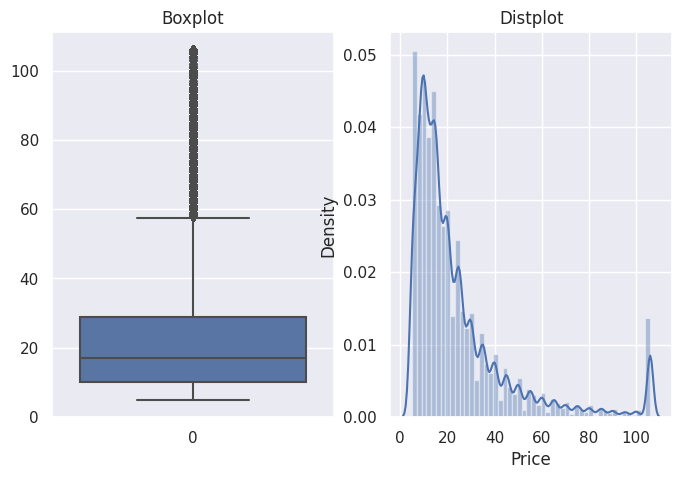

In [ ]:
#setting theme to darkgrid
sns.set_theme(style='darkgrid')
#Setting figure size
plt.figure(figsize=[8,5])
plt.subplot(1,2,1)
sns.boxplot(df['price'])
plt.title('Boxplot')
plt.subplot(1,2,2)
sns.distplot(df['price'])
plt.xlabel('Price')
plt.title('Distplot')
plt.show()

**Insights** :  From above plots we can see that price is affected by outliers . In General it's most common behaviour that money related distributions are right skewed same thing we can observe here.

### Analysis on Item condition ID

In [ ]:
#Values count on item_condition id
df['item_condition_id'].value_counts()

1    637943
3    432062
2    375327
4     31959
5      2384
Name: item_condition_id, dtype: int64

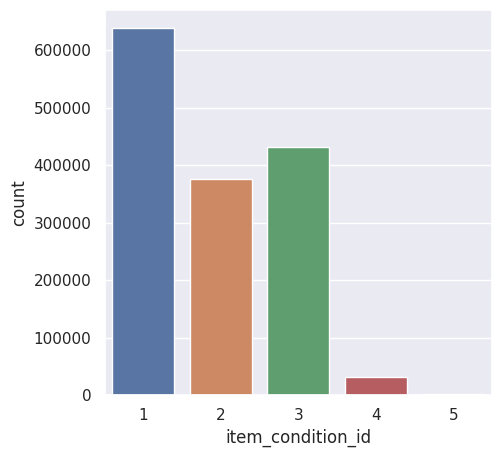

In [ ]:
#taking Similar insights but using catplot
sns.set_theme(style='darkgrid')
plt.figure(figsize=[5,5])
sns.countplot(x = df['item_condition_id'])
plt.show()

**Insights** : 1) Most number of products are with item condition 1 2 3 .
               2) Less numbers of products are with item condition 4,5

**How It's related to Price**

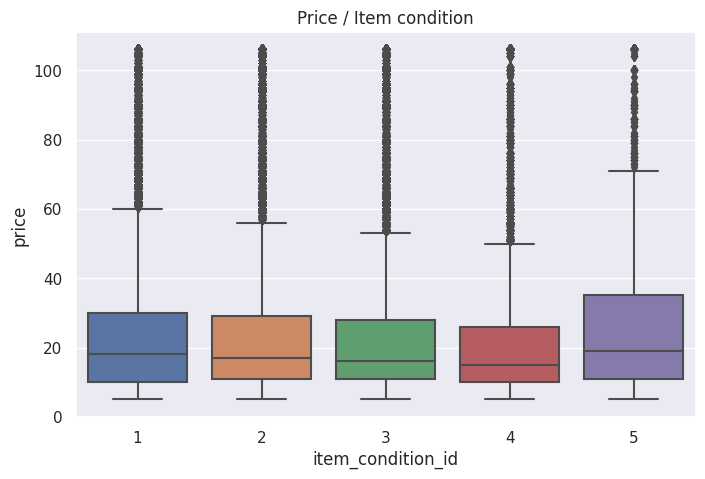

In [ ]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=[8,5])

sns.boxplot(x=df['item_condition_id'],y=df['price'])
plt.title('Price / Item condition')
plt.show()

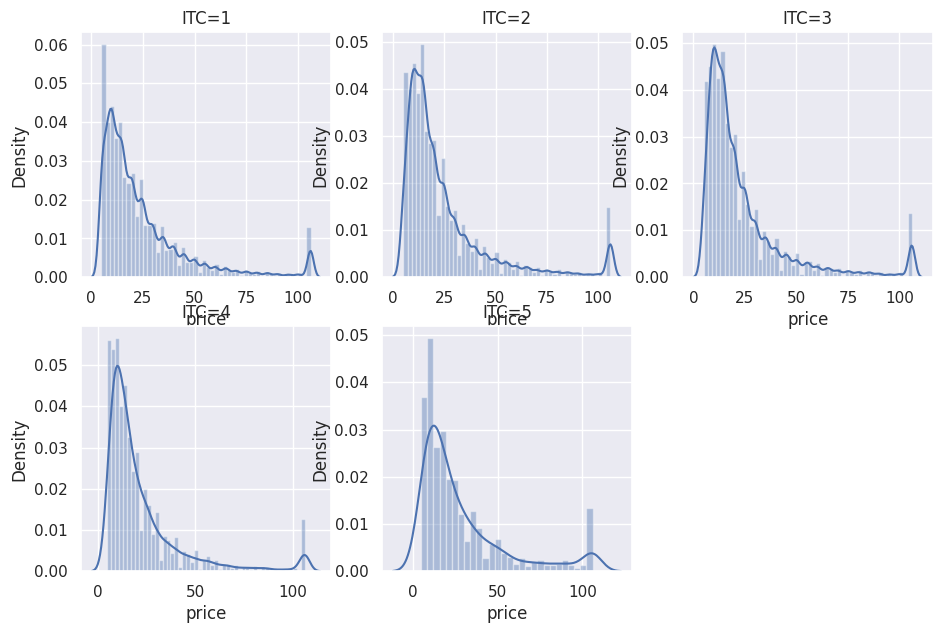

In [ ]:
#Distribution for each Item_condition
plt.figure(figsize=[11,7])
plt.subplot(2,3,1)
sns.distplot(df[df['item_condition_id']==1].price)
plt.title("ITC=1")
plt.subplot(2,3,2)
sns.distplot(df[df['item_condition_id']==2].price)
plt.title("ITC=2")
plt.subplot(2,3,3)
sns.distplot(df[df['item_condition_id']==3].price)
plt.title("ITC=3")
plt.subplot(2,3,4)
sns.distplot(df[df['item_condition_id']==4].price)
plt.title("ITC=4")
plt.subplot(2,3,5)
sns.distplot(df[df['item_condition_id']==5].price)
plt.title("ITC=5")
plt.show()

**Insights** :
 1) As we can see price is varying as per the item coditions
              
 2) Products with Good item condition id having High price range as compare to product with bad item condition



**Item condition Id , Price & shipping**

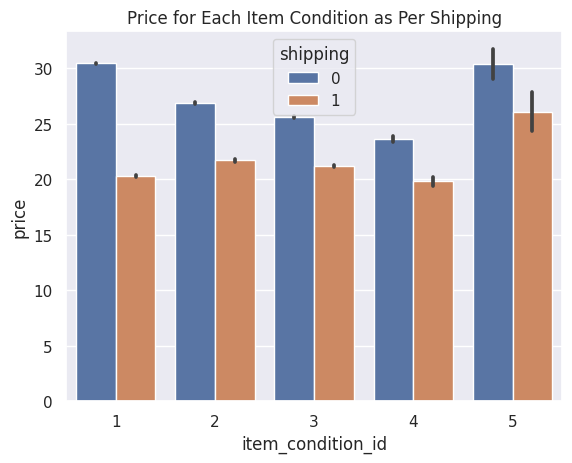

In [ ]:
sns.barplot(x=df['item_condition_id'],y=df['price'],hue=df['shipping'])
plt.title('Price for Each Item Condition as Per Shipping')
plt.show()

**Insights :-**

1) **Mean** is almost same for each **Item_condition_id** When **Shipping=1 i.e charges paid by seller**

2) **Mean** is slightly varying for each **Item_condition_id** When **Shipping=0 i.e charges paid by buyer**

#### Item Condition ID & Brands & Price

In [ ]:
item_price = df.groupby(['brand_name','item_condition_id'])['price'].mean().reset_index().sort_values(by=['brand_name','item_condition_id'])
item_price.describe()

,item_condition_id,price
count,6063.000000,6063.000000
mean,2.407389,25.073436
std,1.137651,17.503910
min,1.000000,5.000000
25%,1.000000,13.857505
50%,2.000000,19.125000
75%,3.000000,29.378989
max,5.000000,106.000000


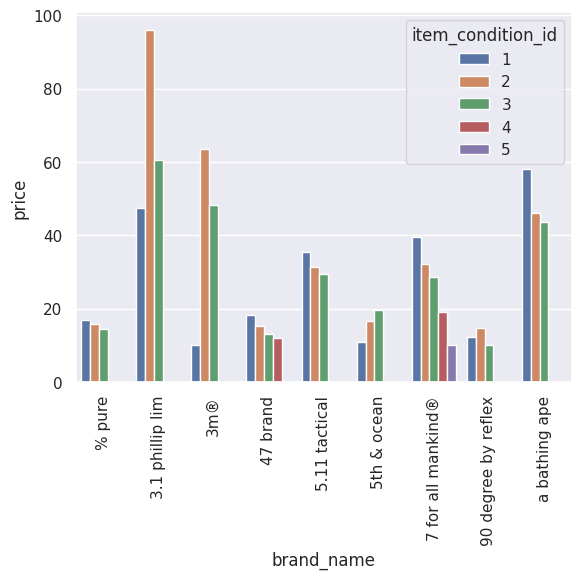

In [ ]:
#Plotting barplot to show relationship between price,brands & item_condition_id
sns.barplot(y=item_price.price.iloc[:30],x=item_price.brand_name.iloc[:30],hue=item_price.item_condition_id.iloc[:30])
plt.xticks(rotation=90)
plt.show()

**Insights -:** Barplot shows average price of products for different brands as per the item condition id

**Plotting same plot but this time with median as mean is highly affected by outliers**

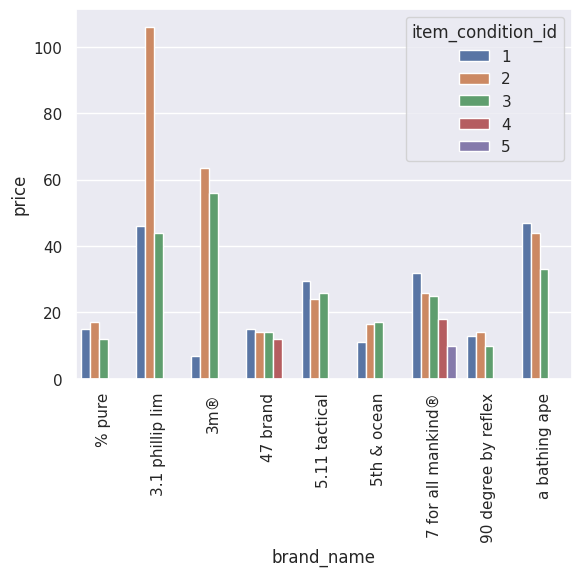

In [ ]:
item_price = df.groupby(['brand_name','item_condition_id'])['price'].median().reset_index().sort_values(by=['brand_name','item_condition_id'])
item_price.describe()
#Plotting barplot to show relationship between price,brands & item_condition_id
sns.barplot(y=item_price.price.iloc[:30],x=item_price.brand_name.iloc[:30],hue=item_price.item_condition_id.iloc[:30])
plt.xticks(rotation=90)
plt.show()

**Info** Barplot shows median price of products for different brands as per item_condition id

#### Category wise numbers of product as per Item_condition_id

In [ ]:
temp_df = df.groupby(['main_category','item_condition_id']).agg('count').reset_index().drop(['brand_name',
       'price', 'shipping', 'item_description', 'category_name',
       'sub_category_1', 'sub_category_2'],axis=1)
temp_df.rename({'name':'count'},axis=1,inplace=True)

In [ ]:
px.bar(temp_df,x='main_category',y='count',color='item_condition_id')

**Insights :-** This plot shows count of products as per the item_condition_id for the different product categories

#### Analysis on shipping with price

 **1 : shipping charges paid by seller**

 **0 : shipping charges paid by buyer**

In [ ]:
#Values counts on shipping
df['shipping'].value_counts()

0    818779
1    660896
Name: shipping, dtype: int64

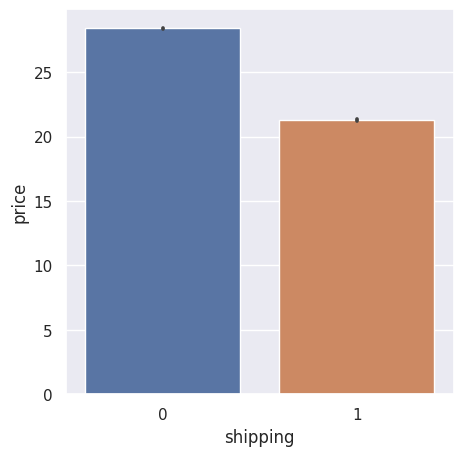

In [ ]:
#Barplot
sns.set_theme(style='darkgrid')
plt.figure(figsize=[5,5])
sns.barplot(x=df['shipping'],y=df['price'])
plt.show()

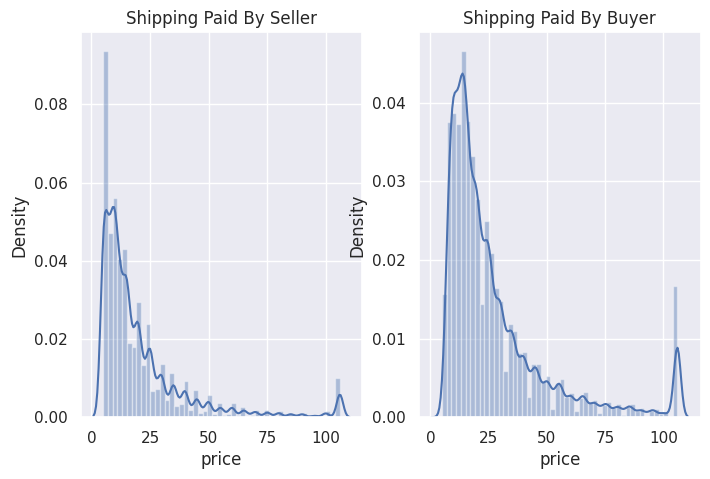

In [ ]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=[8,5])
paid_by_seller = df[df['shipping']==1]
paid_by_buyer = df[df['shipping']==0]
plt.subplot(1,2,1)
sns.distplot(paid_by_seller['price'])
plt.title("Shipping Paid By Seller")
plt.subplot(1,2,2)
sns.distplot(paid_by_buyer['price'])
plt.title("Shipping Paid By Buyer")
plt.show()

**Insights :** Price is high when shipping charges paid by buyer

#### Let's see how product category dealing with shipping ?

In [ ]:
temp_df1 = df.groupby(['main_category','shipping']).agg('count').reset_index().drop(['brand_name',
       'price', 'item_description', 'category_name',
       'sub_category_1', 'sub_category_2','item_condition_id'],axis=1)
temp_df1.rename({'name':'count'},axis=1,inplace=True)

In [ ]:
px.bar(temp_df1,x='main_category',y='count',color='shipping')

**Insight** : As we can see in **Beauty Products** People are getting free shipping

#### Let's  Dive Into Product_category

In [ ]:
#Getting Idea about occurance
df[['main_category','sub_category_1','sub_category_2']].value_counts()

main_category           sub_category_1          sub_category_2         
women                   athletic apparel        pants, tights, leggings    60122
                        tops & blouses          t-shirts                   46349
beauty                  makeup                  face                       34229
                                                lips                       29778
electronics             video games & consoles  games                      26537
                                                                           ...  
kids                    safety                  gates & doorways              11
vintage & collectibles  electronics             clock                         11
sports & outdoors       footwear                men                           11
handmade                glass                   beads                         11
vintage & collectibles  serving                 glassware                     11
Length: 958, dtype: int64

In [ ]:
temp = df['main_category'].value_counts().to_dict()
category = pd.DataFrame({'category':temp.keys(),'counts':temp.values()})

In [ ]:
px.bar(category,x='category',y='counts',title='Top Selling Main Categories')

**Insights :-**  

1) Top 3 most selling main categories are women , beauty & kids


In [ ]:
#Plotting Sub_categories as per counts
temp = df['sub_category_1'].value_counts().to_dict()
category = pd.DataFrame({'category':temp.keys(),'counts':temp.values()})
px.bar(category.head(30),x='category',y='counts')

**Insights :-**

Athletic apparel , makeup , tops & blouse are most selling top 3 sub categories

In [ ]:
temp = df['sub_category_2'].value_counts().to_dict()
category = pd.DataFrame({'category':temp.keys(),'counts':temp.values()})
px.bar(category.head(30),x='category',y='counts')

**Insights :-**

t-shirts , pants & leggings , face are most selling top 3 exact products

In [ ]:
#taking average price by using groupby on category_name
temp_two = df.groupby(['main_category','sub_category_1','sub_category_2'])['price'].mean().reset_index().sort_values(by='price',ascending=False)
temp_two.describe()

,price
count,958.000000
mean,24.170274
std,12.665838
min,5.868974
25%,16.158985
50%,20.947383
75%,28.088176
max,106.119048


In [ ]:
#Taking Top 10 using plotly
px.bar(temp_two.iloc[:10],x='sub_category_2',y='price',color='sub_category_1',title='Top 10 sub_categories with Highest Avg Price')

**Insights :-**

1) Core Product with highest Avg price is air conditioners which belongs to home appleance sub_category

In [ ]:
px.bar(temp_two.tail(10),x='sub_category_2',y='price',color='sub_category_1',title='Top 10 sub_categories with Lowest Avg Price')

**Insights :-**

Magnet Products with lowest Avg price is  which belongs to home appleance sub_category

#### Brands as Per Occurance

In [ ]:
temp = df['brand_name'].value_counts().to_dict()
brands = pd.DataFrame({'Brand_Name':temp.keys(),'Counts':temp.values()})
brands.drop(0,inplace=True)

In [ ]:
px.bar(brands.head(10),x='Brand_Name',y='Counts',title= 'Most Selling Brands')

**Insights -:**

pink , nike & victoria's secret are top 3 most selling brands

In [ ]:
px.bar(brands.tail(10),x='Brand_Name',y='Counts',title= 'Least Selling Brands')

**Insights :-**

oneida , vitamin a , freshly picked are least selling brands

**Brands with Highest Avg Price**

In [ ]:
#Taking average price by groupby on brands name
top_brands = df.groupby('brand_name')['price'].mean().reset_index().sort_values(by='price',ascending=False)
top_brands.describe()

,price
count,1682.000000
mean,25.732750
std,16.060915
min,6.666667
25%,15.238312
50%,20.136979
75%,30.145438
max,100.803279


In [ ]:
#Plotting BarPlot using plotly
px.bar(top_brands.iloc[:10],x='brand_name',y='price',title='Brands with Highest Avg Price')

**Insights :-**

tieks , david yurman , jovani are amongst the top 3 brands with highest average price

In [ ]:

px.bar(top_brands.tail(10),x='brand_name',y='price',title='Brands with Lowest Avg Price')

**Insights :-**

bausch & lomb , milani cosmetics , slime are the brands with less average price

#### Categeory , Brands and Price

In [ ]:
temp_th = df.groupby(['main_category','brand_name'])['price'].mean().reset_index().sort_values(by='price',ascending=False)
temp_th.describe()

,price
count,4088.000000
mean,24.849933
std,17.382159
min,5.000000
25%,14.000000
50%,19.273864
75%,29.000000
max,106.000000


In [ ]:
px.bar(temp_th.iloc[:15],x='brand_name',y='price',color='main_category',title='Brands with Highest Avg Price in Category')

**Insights :-**

frye , alexander mcqueen are brands with highest average price in vintage & collectibles category

In [ ]:
px.bar(temp_th.tail(15),x='brand_name',y='price',color='main_category',title='Brands with Lowest Avg Price in Category')

**Insights -:**
elmers , nba are brands with lowest average price in vintage & collectibles category

#### Analysis on Description

In [ ]:
#Calculating length of item_description
df['Length_of_descr'] = df['item_description'].apply(lambda x: len(x.split(' ')))

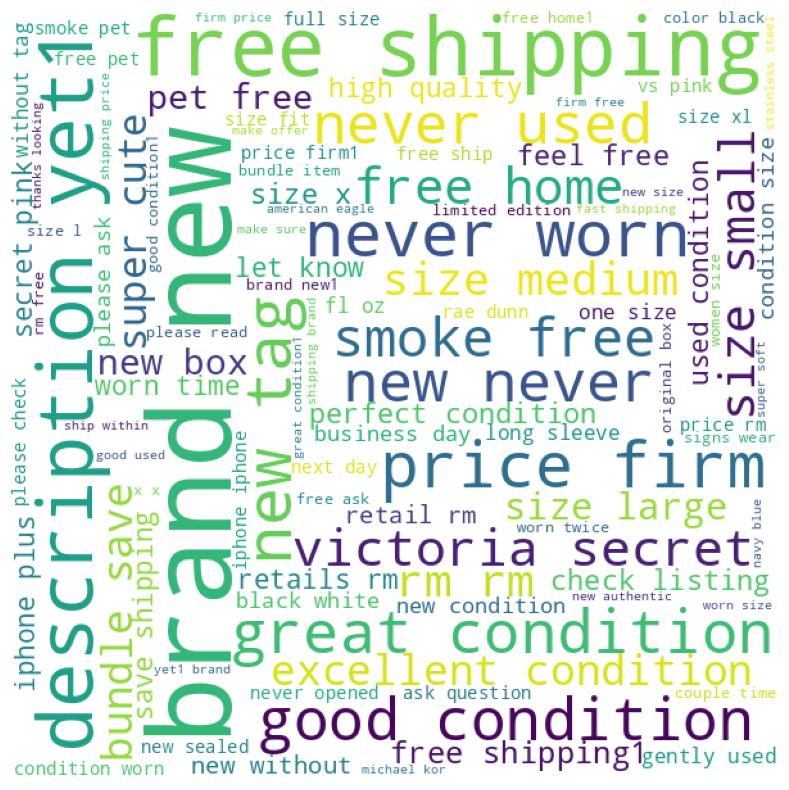

<Figure size 640x480 with 0 Axes>

In [ ]:
#wordcloud to see most occuring words
stopwords=set(STOPWORDS)
word_cloud = WordCloud(width = 600, height = 600,background_color ='white', stopwords=stopwords,min_font_size = 10).generate("1 ".join(df['item_description']))
plt.figure(figsize = (15, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
plt.savefig('wordlcd.png')

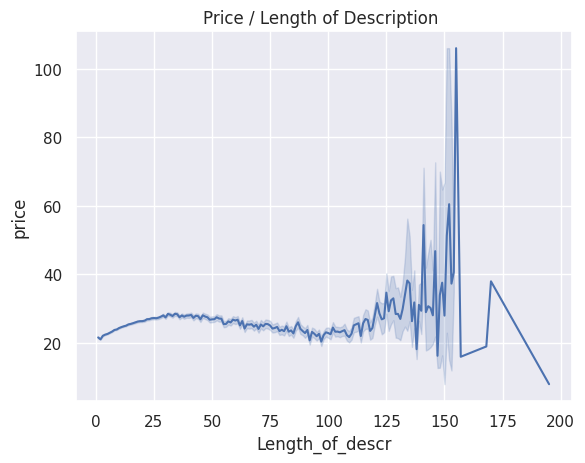

In [ ]:
#lineplot
sns.lineplot(x = df.Length_of_descr,y = df.price)
plt.title('Price / Length of Description ')
plt.show()

**Insights -:**

This is how price  varies when length of item_description increasing

**Let's see how price changes with item_condition_id as per length of Description**

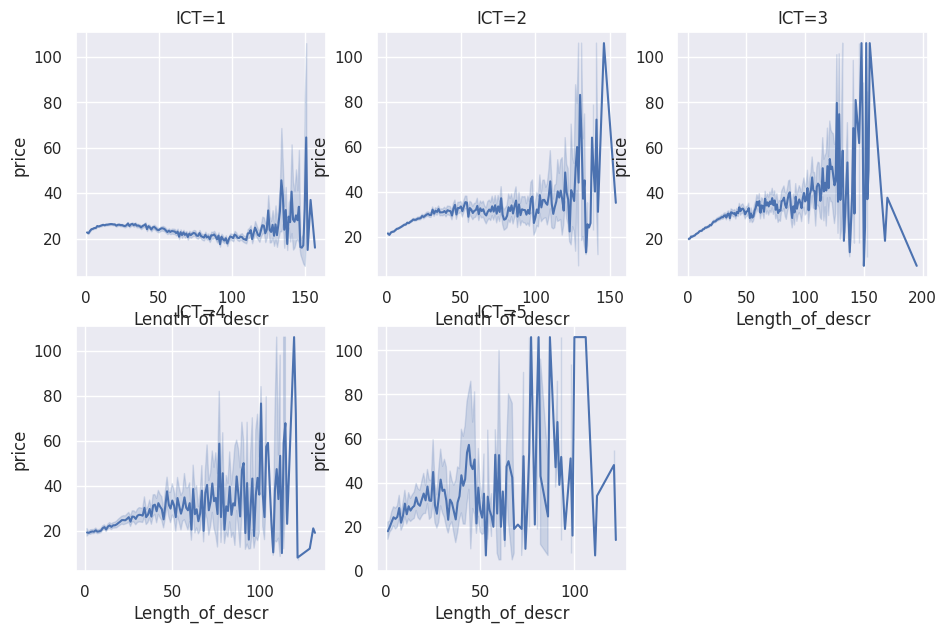

In [ ]:
plt.figure(figsize=[11,7])
plt.subplot(2,3,1)
sns.lineplot(x=df[df['item_condition_id']==1].Length_of_descr,y=df[df['item_condition_id']==1].price)
plt.title("ICT=1")
plt.subplot(2,3,2)
sns.lineplot(x=df[df['item_condition_id']==2].Length_of_descr,y=df[df['item_condition_id']==2].price)
plt.title("ICT=2")
plt.subplot(2,3,3)
sns.lineplot(x=df[df['item_condition_id']==3].Length_of_descr,y=df[df['item_condition_id']==3].price)
plt.title("ICT=3")
plt.subplot(2,3,4)
sns.lineplot(x=df[df['item_condition_id']==4].Length_of_descr,y=df[df['item_condition_id']==4].price)
plt.title("ICT=4")
plt.subplot(2,3,5)
sns.lineplot(x=df[df['item_condition_id']==5].Length_of_descr,y=df[df['item_condition_id']==5].price)
plt.title("ICT=5")
plt.show()

**Insights :-**

As we can see there is significant difference in price as length of description & item_condition id

**Let's see how price changes with Shipping as per length of Description**

<Axes: xlabel='Length_of_descr', ylabel='price'>

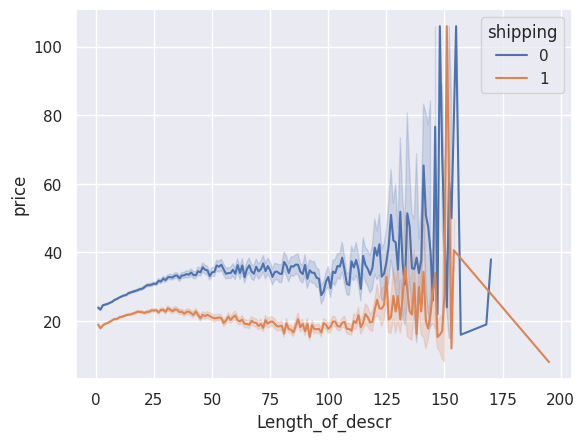

In [ ]:
sns.lineplot(x=df['Length_of_descr'],y=df['price'],hue=df['shipping'])

**Insights -:**

This show price changes as length of description depending on shipping

#### Heatmap

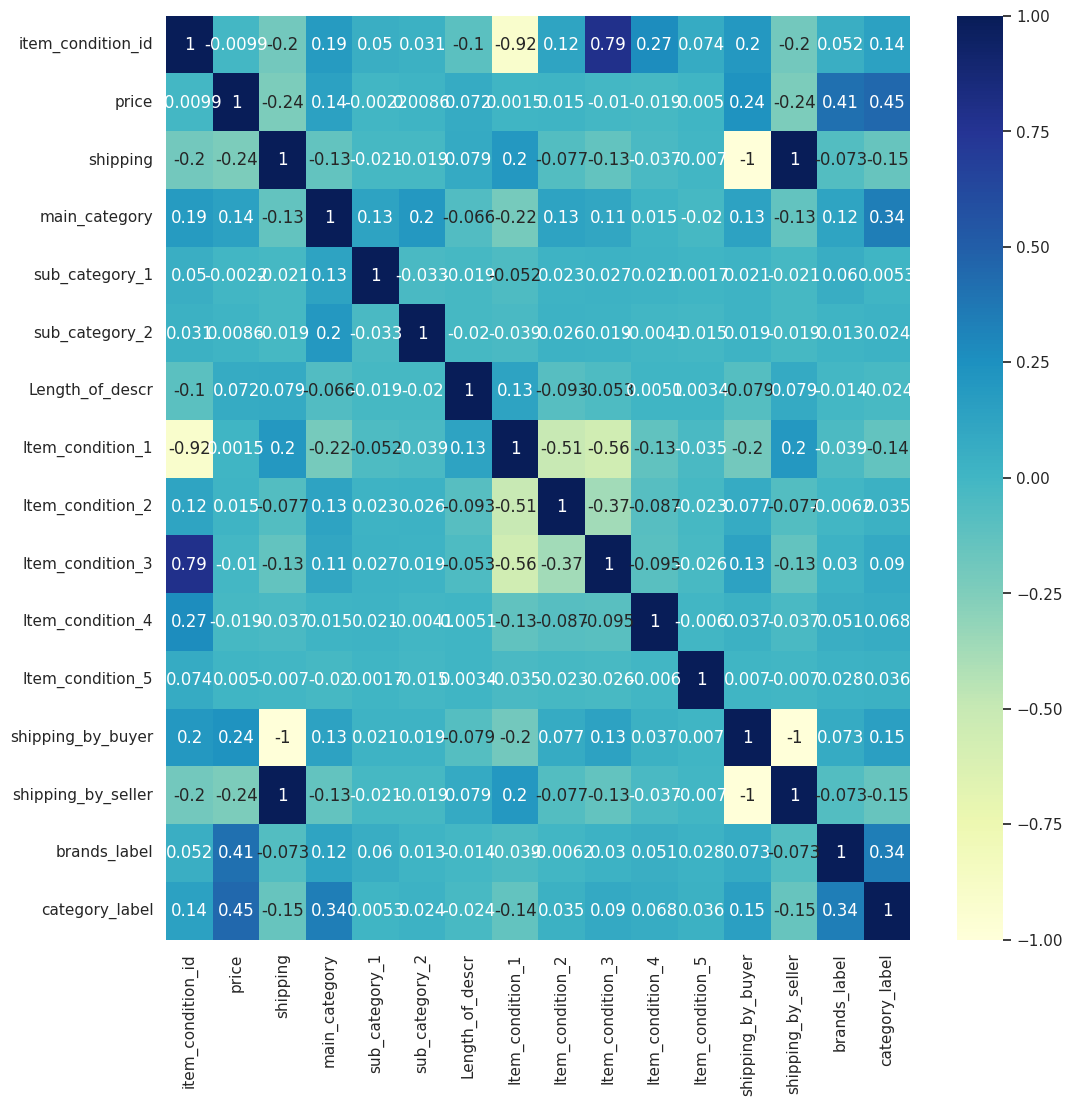

In [ ]:
corr = df.corr(method='spearman')
plt.figure(figsize=[12,12])
sns.heatmap(corr,annot=True,cmap="YlGnBu")
plt.show()

### Statistical Analysis

#### tests on Price

Conducting Statistical tests is used for checking sample is coming from normal distribution or not

**Setting Hypothesis**

**Ho(Null Hypothesis) :** Data comes from normal distribution

**Ha(Alternate Hypothesis) :** Data does not comes from normal distribution

**Shapiro wilk Test**

In [ ]:
#implementation through scipy.stats lib
alpha = 0.05
f_stats,p_value = stats.shapiro(df['price'].iloc[:5000])
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


#### KS Test

In [ ]:
#implementation of KS test
alpha = 0.05
f_stats, p_value = stats.kstest(df['price'],'norm')
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

**Inference** : From the result of test we can say that data does not follow normal distribution

### Checking variance across different category

#### Null Hypothesis Ho -- u1=u2 Mean accross different category is equal

#### Alternate Hypothesis Ha --- u1 != u2 Mean is not same


**Why Anova or Levene's Test ?** : It is used to test difference among the means of different samples . Our motive is to test the difference
between mean price for each product category . Used when sample are two or more

In [ ]:
#Taking Price with respect to each transcation converting it into tuple
product_cat = tuple(df.groupby('category_name')['price'].apply(list).reset_index()['price'])

#### Anova Test

In [ ]:
#Anova Test using scipy.stats
f_stat,p_value = stats.f_oneway(*product_cat)
#Setting Significance level at 0.05%
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


#### Levene's Test

In [ ]:
f_stats,p_value = stats.levene(*product_cat)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


**Inference** : From the result of test we can say that there is significance difference between means of different category & we can reject null hypothesis

### Checking variance across different brands

#### Null Hypothesis Ho -- u1=u2 Mean accross different brands is equal

#### Alternate Hypothesis Ha --- u1 != u2 Mean is not same


In [ ]:
brands = tuple(df.groupby('brand_name')['price'].apply(list).reset_index()['price'])

In [ ]:
f_stats,p_value = stats.f_oneway(*brands)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


In [ ]:
f_stats,p_value = stats.levene(*brands)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


**Inference** : From the result of test we can say that there is significance difference between means of different brands & we can reject null hypothesis

### Item condition

#### Null Hypothesis Ho -- u1=u2 Mean across different item condition is equal
#### Alternate Hypothesis Ha --- u1 != u2 Mean  across different item condition is not same

In [ ]:
item_condition = tuple(df.groupby('item_condition_id')['price'].apply(list).reset_index()['price'])

In [ ]:
#Implementing one way anova test
fstats,p_value = stats.f_oneway(*item_condition)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


In [ ]:
f_stats,p_value = stats.levene(*item_condition)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


**Inference** : From the result of test we can say that there is significance difference between means of different item condition & we can reject null hypothesis

### T-test

**Why T-test ?** : T-test is used to compare the difference between mean of two sample . As we have two variables in shipping column we can use t-test to compare mean of price when shipping charges paid by buyer & seller.

#### Null Hypothesis Ho -- u1=u2 Mean is equal for shipping charges paid by buyer or seller
#### Alternate Hypothesis Ha --- u1 != u2 Mean is  not same for shipping charges

In [ ]:
#Splitting data
by_seller = df[df['shipping']==1]
by_buyer = df[df['shipping']==0]

In [ ]:
#implementing via stats.ttest_ind
f_stat,p_value = stats.ttest_ind(by_buyer['price'],by_seller['price'])
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


**Inference** : From the result of test we can say that there is significance difference between means of price when shipping charges paid by buyer & Seller we can reject null hypothesis

### Chi - X2 Test

#### Ho -: Variables are independent
#### Ha -: Variables are dependent

#### Checking relation between Shipping & Product category

In [ ]:
#Creating contengency table for shipping & product category
contengency_table = pd.crosstab(df['shipping'],df['category_name'])
_,p_value,_,_ = stats.chi2_contingency(contengency_table)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


**Inference :** As null hypothesis got rejected we can say that there is significant relationship between shipping & Category_name


### Chi2 test - on Item_condition_id & Brands

#### Ho -: Variables are independent
#### Ha -: Variables are dependent

In [ ]:
contengency_table = pd.crosstab(df['item_condition_id'],df['brand_name'])
_,p_value,_,_ = stats.chi2_contingency(contengency_table)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


**Inference :** As null hypothesis got rejected we can say that there is significant relationship between item_condition id & brand name

### Item Description & item-desc id

In [ ]:
contengency_table = pd.crosstab(df['item_condition_id'],df['item_description'])
_,p_value,_,_ = stats.chi2_contingency(contengency_table)
alpha = 0.05
if p_value > alpha :
  print(" Null Hypothesis cannot be rejected")
else :
  print("Null Hypothesis can be rejected")

Null Hypothesis can be rejected


**Inference :** As null hypothesis got rejected we can say that there is significant relationship between item_condtion_id & item_description

#### Feature Engg

In [ ]:
#applying one hot encoding on Item_condition id
df[['Item_condition_1','Item_condition_2','Item_condition_3','Item_condition_4','Item_condition_5']] = pd.get_dummies(df['item_condition_id'],prefix='Item_condition')
#One hot encoding on shipping
df[['shipping_by_buyer','shipping_by_seller']] = pd.get_dummies(df['shipping'])

In [ ]:
#Applying Label Encoding on Category columns
labels = LabelEncoder()
labels.fit(df['main_category'])
df['main_category'] = labels.transform(df['main_category'])
labels.fit(df['sub_category_1'])
df['sub_category_1'] = labels.transform(df['sub_category_1'])
labels.fit(df['sub_category_2'])
df['sub_category_2'] = labels.transform(df['sub_category_2'])

#### Feature Transformation

In [ ]:
#Taking average by brands
brands = df.groupby('brand_name')['price'].mean().reset_index()
#Megring dataframe with average price on brands name
df = df.merge(brands,on='brand_name',how='inner')
#Renaming columns
df.rename(columns={'price_x':'price','price_y':'avg_price_by_brands'},inplace=True)
#Creating lables based on quartile range using pd.qcut
df['brands_label'] = pd.qcut(df['avg_price_by_brands'],q=6,labels=range(1,6),duplicates='drop')
#Taking average by category
category = df.groupby('category_name')['price'].mean().reset_index()
#Inner join on category name
df = df.merge(category,on='category_name',how='inner')
#Renaming old columns as required
df.rename(columns={'price_x':'price','price_y':'avg_price_by_category'},inplace=True)
#creating lables based quartile range
df['category_label'] = pd.qcut(df['avg_price_by_category'],q=10,labels=range(1,11))
df['category_label'] = df['category_label'].astype('int')
df['brands_label'] = df['brands_label'].astype('int')
df.drop(['avg_price_by_category','avg_price_by_brands'],axis=1,inplace=True)

### splitting data for train , test & validation

In [ ]:
#Selecting Requiered Columns
X = df[['brands_label', 'category_label', 'Item_condition_1','Item_condition_2', 'Item_condition_3', 'Item_condition_4','Item_condition_5', 'shipping_by_buyer', 'shipping_by_seller','main_category', 'sub_category_1',
       'sub_category_2','name','item_description']]
y = df['price']

In [ ]:
#Splitting data for training , testing & validation
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=14)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.15,random_state=16)

**Vectorization**

In [ ]:
#Applying TF-IDF Vectorizer on Item_description with hyperparameter as max_feature , min_df
vect = TfidfVectorizer(min_df=5,max_features=7000,stop_words='english')
#fitting data
vect.fit(X_train['item_description'])
#transforming into vector
train_desc = vect.transform(X_train['item_description'])
test_desc = vect.transform(X_test['item_description'])
val_desc = vect.transform(X_val['item_description'])

In [ ]:
#Applying Counter Vector on name
count_vect = CountVectorizer(max_features=4000,min_df=5)
count_vect.fit(X_train['name'])
train_name = count_vect.transform(X_train['name'])
test_name = count_vect.transform(X_test['name'])
val_name = count_vect.transform(X_val['name'])

In [ ]:
#Dropping unwanted columns
X_train.drop(['name','item_description'],axis=1,inplace=True)
X_test.drop(['name','item_description'],axis=1,inplace=True)
X_val.drop(['name','item_description'],axis=1,inplace=True)

In [ ]:
#Merging data using hstack
X_train = hstack((X_train.values,train_desc,train_name))
X_test = hstack((X_test.values,test_desc,test_name))
X_val = hstack((X_val.values,val_desc,val_name))

#### Model Building

**Linear Regression**

In [ ]:
#Simple linear Regression model
linear = LinearRegression()
linear.fit(X_train,y_train)
print(f"Performance On validation Data ")
l_pred = linear.predict(X_val)
print("---"*25)
print(f"Mean Absolute Error :-{mean_absolute_error(y_val,l_pred)}")
print(f"Mean Squared Error :-{mean_squared_error(y_val,l_pred)}")
print("---"*25)

Performance On validation Data 
---------------------------------------------------------------------------
Mean Absolute Error :-10.297000203069874
Mean Squared Error :-234.1417497909497
---------------------------------------------------------------------------


**Implementing Random Forest**

In [ ]:
random_forest = RandomForestRegressor(n_estimators=200,max_depth=7)
random_forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=200)

In [ ]:
print(f"Performance On validation Data ")
r_pred = random_forest.predict(X_val)
print("---"*25)
print(f"Mean Absolute Error :-{mean_absolute_error(y_val,r_pred)}")
print(f"Mean Squared Error :-{mean_squared_error(y_val,r_pred)}")
print("---"*25)

Performance On validation Data 
---------------------------------------------------------------------------
Mean Absolute Error :-11.45131322209818
Mean Squared Error :-299.0410906392461


**XGBoost Regressor**

In [ ]:
#Finding best hyperparameter for Light GBM Regressor
parameters = {'n_estimators':[150,200,250,300,400],'max_depth':[7,9,11],'learning_rate':[0.3,0.4,0.5]}
random_search = RandomizedSearchCV(estimator=XGBRegressor(),param_distributions=parameters,cv=2,n_iter=10)
random_search.fit(X_train,y_train)
print(f'Best Parametes {random_search.best_params_}')

In [ ]:
xgb_reg = XGBRegressor(n_estimators=350,max_depth=9,learning_rate=0.3)
xgb_reg.fit(X_train,y_train)
#Predicting validation data
print("Performance on validation Data ")
print('---'*25)
y_pxval = xgb_reg.predict(X_val)
print(f"Mean Absolute Error :-{mean_absolute_error(y_val,y_pxval)}")
print(f"Mean Squared Error :-{mean_squared_error(y_val,y_pxval)}")
print('---'*25)

Performance on validation Data 
---------------------------------------------------------------------------
Mean Absolute Error :-9.110654837854367
Mean Squared Error :-201.72338488102267
---------------------------------------------------------------------------


**LightGBM Implementation**

Finding Best Parameters

In [ ]:
#Finding best hyperparameter for Light GBM Regressor
parameters = {'n_estimators':[150,200,250,300,400],'max_depth':[7,9,11],'learning_rate':[0.3,0.4,0.5]}
random_search = RandomizedSearchCV(estimator=LGBMRegressor(),param_distributions=parameters,cv=2,n_iter=10)
random_search.fit(X_train,y_train)
print(f'Best Parametes {random_search.best_params_}')


In [ ]:
lgb_reg = LGBMRegressor(n_estimators=400,max_depth=11,learning_rate=0.4,reg_lambda=0.2)
lgb_reg.fit(X_train,y_train)
print("Performance on Validation Data")
print('---'*25)
y_pval = lgb_reg.predict(X_val)
print(f"Mean Absolute Error :-{mean_absolute_error(y_val,y_pval)}")
print(f"Mean Squared Error :-{mean_squared_error(y_val,y_pval)}")
print('---'*25)

Performance on Validation Data
---------------------------------------------------------------------------
Mean Absolute Error :-9.023713960086619
Mean Squared Error :-195.75260747852775
---------------------------------------------------------------------------


**Final Model**

**LightGBMRegressor Has perform well for training & validation data and also able to handle noise in better way**

In [ ]:
print("Performance on Final Testing")
print('---'*25)
y_ptest = lgb_reg.predict(X_test)
print(f"Mean Absolute Error :-{mean_absolute_error(y_test,y_ptest)}")
print(f"Mean Squared Error :-{mean_squared_error(y_test,y_ptest)}")
print('---'*25)

Performance on Final Testing
---------------------------------------------------------------------------
Mean Absolute Error :-9.00603174562224
Mean Squared Error :-194.70449408630083
---------------------------------------------------------------------------


### Insights



1.   Price is affected by outliers . In General it's most common behaviour that money related distributions are right skewed same thing we can observe here.
2.   Most number of products are with item condition id  1 2 3 &  less numbers of products are with item condition id  4,5

3.  As we can see price is varying as per the item conditions
4.   Products with Good item condition id having High price range as compare to product with bad item condition
5.   Mean is almost same for each Item_condition_id When Shipping=1 i.e charges paid by seller.
6.   Mean is slightly varying for each Item_condition_id When Shipping=0 i.e charges paid by buyer.

1.  Women category has most numbers of product in each category

1.  On Beauty Products People are getting free shipping
2.  Top 3 most selling main categories are women , beauty & kids

2.   Athletic apparel , makeup , tops & blouse are most selling top 3 sub categories

1.   T-shirts , pants & leggings , face are most selling top 3 core products
2.  Product with highest Avg price is air conditioners which belongs to home appleance sub_category
1.   Magnet Products with lowest Avg price is  which belongs to home appleance sub_category
2.   Pink , Nike & victoria's secret are top 3 most selling brands
1.   Oneida , vitamin a , freshly picked are least selling brands
2.   Tieks , david yurman , jovani are amongst the top 3 brands with highest average price and -- bausch & Lomb , milani cosmetics , slime are the brands with less average price
1.  There is significant difference in price as length of description & item_condition id
















# Future work



1.   As target column is highly affected by presence of outliers , that can easily messup any model performance so need to work more on outlier handling
2.  Need to work on text data to get out more from model
1.  Machine Learning models can be optimize further
2.  We can use deep learning techniques for this dataset


